In [1]:
import tensorflow as tf
import numpy as np
import random

import os
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import optimizers, utils

from keras import layers
from keras import losses
from keras import callbacks
from keras.models import Model, Sequential

from keras import backend as K

In [2]:
### Ensuring reproducibility

os.environ['PYTHONHASHSEED'] = '0'
np.random.default_rng(2021)
random.seed(2021)

tf.random.set_seed(2021)

### Session configuration
tf.config.threading.set_inter_op_parallelism_threads(3)
tf.config.threading.set_intra_op_parallelism_threads(1)

### Create computational graph via session config
#ssess = tf.Session(graph = tf.get_default_graph(), config = sess_config)

### Set the graph above as default graph
#K.set_session(sess)

In [3]:
class AE(Model):
    
    ''' Class blueprint for Autoencoder. '''
    
    def __init__(self, optimizer, latent_dims):
        super().__init__()
        self.latent_dims = latent_dims
        self.optimizer = optimizer
        self.encoder = self.generate_encoder(latent_dims = self.latent_dims)
        self.decoder = self.generate_decoder(latent_dims = self.latent_dims)
        
        self.encoder.compile(loss = 'binary_crossentropy', optimizer = self.optimizer)
        self.decoder.compile(loss = 'binary_crossentopy', optimizer = 'adam')
        
    def generate_encoder(self, latent_dims):
        model = Sequential([layers.Input(shape = [28, 28, 1]),
                            #tf.keras.layers.experimental.preprocessing.Rescaling(1/255),
                            layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides = 1),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(),
                            
                            layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', strides = 2),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(),
                            
                            layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', strides = 2),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(),
                            
                            layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', strides = 1),
                            layers.BatchNormalization(),
                            layers.LeakyReLU(),
                            
                            layers.Flatten(),
                            layers.Dense(units = self.latent_dims)
                           ])
        return model
    
    def generate_decoder(self, latent_dims):
        model = Sequential()
        
        model.add(layers.Input(shape = [self.latent_dims]))
        model.add(layers.Dense(units = 7*7*16, activation = 'relu'))
        model.add(layers.Reshape(target_shape = [7, 7, 16]))
        
        model.add(layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 1))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        
        model.add(layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        
        model.add(layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        
        model.add(layers.Conv2D(filters = 32, kernel_size = 4, strides = 1, padding = 'valid'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        
        model.add(layers.Conv2D(filters = 32, kernel_size = 4, strides = 1, padding = 'valid'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        
        model.add(layers.Conv2D(filters = 32, kernel_size = 4, strides = 1, padding = 'valid'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        
        model.add(layers.Conv2D(filters = 1, kernel_size = 3, strides = 1, padding = 'valid', activation = 'sigmoid'))
        
        return model
    
    def encode(self, x):
        z_ = self.encoder(x)
        return z_
    
    def decode(self, x):
        sample = self.decoder(x)
        return sample
    
    def call(self, x):
        z_ = self.encode(x)
        y = self.decode(z_)
        
        return y

 def call(self, x):
        y = self.encoder(x)
        y = self.decoder(y)
        return y

In [4]:
os.listdir(os.getcwd())

['.ipynb_checkpoints', 'artefacts', 'MNIST Autoencoder.ipynb', 'scripts']

In [5]:
DIR = os.path.join(os.getcwd().replace('MNIST Autoencoder', ''), 'trainingSet', 'trainingSet')

In [6]:
print(DIR)

C:\Users\PROBOOK\Desktop\ML Projects\Deep Learning Projects\MNIST\MNIST\trainingSet\trainingSet


In [8]:
### Import dataset
train_images = utils.image_dataset_from_directory(DIR, image_size = (28, 28), color_mode = 'grayscale',
                                                  batch_size = 16, shuffle = True, labels = None)

Found 42000 files belonging to 1 classes.


In [9]:
len(train_images)

2625

In [10]:
### Scale pixel values
train_images = train_images.map((lambda x: (x/255, x/255)), num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [11]:
### Split dataset object
test_x = train_images.skip(625)
train_x = train_images.take(2000)

In [12]:
def generate_and_save_images(model, sample, variational = False, save_image = False):
    
    ''' Generate images via autoencoder, with options to save. '''
    
    if variational:
        m, l = model.encode(sample)
        z = model.reparametrize(m, l)
        z = model.decode(z)
    else:
        z = model.encode(sample)
        z = model.decode(z)
    
    plt.figure(figsize = (15, 10))
    for i in range(z.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(tf.squeeze(z[i]), cmap = 'gray')
        
    if save_image:
        plt.savefig(f'Auto-generated MNIST Image for Epoch {epoch+1:03d}.png', dpi = 300)
    plt.show()

In [13]:
### Instantiate model objects
model = AE(latent_dims = 16, optimizer = optimizers.Adam(learning_rate = 8e-9))
inputs = layers.Input(shape = [28, 28, 1])
autoencoder = Model(inputs = inputs, outputs = model.decoder(model.encoder(inputs)))

### Define loss function
def r_loss(a, b):
    
    ''' Mean squared error loss. '''
    
    return tf.reduce_mean(tf.square(a - b), axis = [0, 1, 2])

autoencoder.compile(loss = r_loss, optimizer = 'adam')

In [14]:
### Autoencoder architecture
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 16)                143760    
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         128561    
Total params: 272,321
Trainable params: 271,361
Non-trainable params: 960
_________________________________________________________________


In [15]:
### Encoder architecture
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          3

In [16]:
### Decoder architecture
model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               13328     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 9, 64)          9280      
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 19, 19, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 19, 19, 64)       

In [17]:
### Compile model
model.compile(loss = r_loss, optimizer = optimizers.Adam(learning_rate = 3e-6))
save_model = callbacks.ModelCheckpoint('artefacts/autoencoder-weights.h5')

In [18]:
sample = [b for b in test_x.take(1)]
s = sample[0][0]

In [19]:
model(s)

<tf.Tensor: shape=(16, 28, 28, 1), dtype=float32, numpy=
array([[[[0.49999183],
         [0.4999969 ],
         [0.5000032 ],
         ...,
         [0.49998114],
         [0.49999753],
         [0.50001574]],

        [[0.4999904 ],
         [0.499981  ],
         [0.4999992 ],
         ...,
         [0.5000022 ],
         [0.49999407],
         [0.4999948 ]],

        [[0.5000007 ],
         [0.49997965],
         [0.49998853],
         ...,
         [0.49999228],
         [0.49999905],
         [0.49998164]],

        ...,

        [[0.49999687],
         [0.49995846],
         [0.4999719 ],
         ...,
         [0.49998093],
         [0.5000073 ],
         [0.4999652 ]],

        [[0.49998692],
         [0.49999103],
         [0.5000066 ],
         ...,
         [0.50000197],
         [0.49999422],
         [0.49999776]],

        [[0.49997872],
         [0.49994949],
         [0.5000088 ],
         ...,
         [0.49998564],
         [0.4999863 ],
         [0.49999222]]],


   

In [20]:
### Load weight checkpoint
model.load_weights(os.path.join(os.getcwd(), 'artefacts', 'final-autoencoder-weights-2.h5'))

In [21]:
### Train model
model.fit(train_x, epochs = 5, shuffle = True)

Epoch 1/5
2000/2000 [==============================] - 1723s 860ms/step - loss: 0.0194
Epoch 2/5
2000/2000 [==============================] - 1738s 869ms/step - loss: 0.0188
Epoch 3/5
2000/2000 [==============================] - 1630s 815ms/step - loss: 0.0183
Epoch 4/5
2000/2000 [==============================] - 1782s 891ms/step - loss: 0.0179
Epoch 5/5
2000/2000 [==============================] - 1717s 859ms/step - loss: 0.0174


In [22]:
### Save model weights
model.save_weights('artefacts/final-autoencoder-weights-3.h5')

In [23]:
sample = [b for b in test_x.take(1)]

In [24]:
sample[0][0].shape

TensorShape([16, 28, 28, 1])

In [25]:
s = sample[0][0]

In [26]:
### Encode actual image batch
z_= model.encode(s)

In [27]:
z_.shape

TensorShape([16, 16])

In [28]:
z_

<tf.Tensor: shape=(16, 16), dtype=float32, numpy=
array([[ -4.617246  ,   3.1636422 ,   2.162397  ,  -5.1405272 ,
          0.6187757 ,  -5.6633854 ,   5.4054074 , -10.743835  ,
          2.0453327 ,   2.2211692 ,  -6.62665   ,  -0.973653  ,
          2.8593721 ,  -3.4830554 ,  -6.9435983 ,  -4.0701103 ],
       [ -0.5482579 ,   2.8444488 ,   2.902329  ,  -4.8545365 ,
          3.8187847 ,  -5.67776   ,   5.391009  , -12.128227  ,
          3.4585156 ,   3.8490312 ,  -6.283584  ,   0.8175231 ,
         -0.7907409 ,  -4.539725  ,  -7.166018  ,  -4.6146927 ],
       [  0.06126494,   5.3524623 ,   4.426926  ,  -4.392462  ,
          2.3414452 ,  -7.2010837 ,   7.0993056 , -14.616398  ,
          5.4044356 ,   4.5341616 ,  -7.2808332 ,  -2.1735842 ,
         -1.6029773 ,  -4.624618  ,  -6.4146786 ,  -5.1492634 ],
       [ -3.2323205 ,   4.253186  ,   2.148378  ,  -2.5579588 ,
          0.45506147,  -5.9645824 ,   5.6640844 , -11.684709  ,
         -0.11086509,   3.87567   ,  -7.1294756 ,  

In [29]:
### Decode batch encoding
s_ = model.decode(z_)

In [30]:
tf.reduce_mean(s_ - s).numpy()

0.0047726803

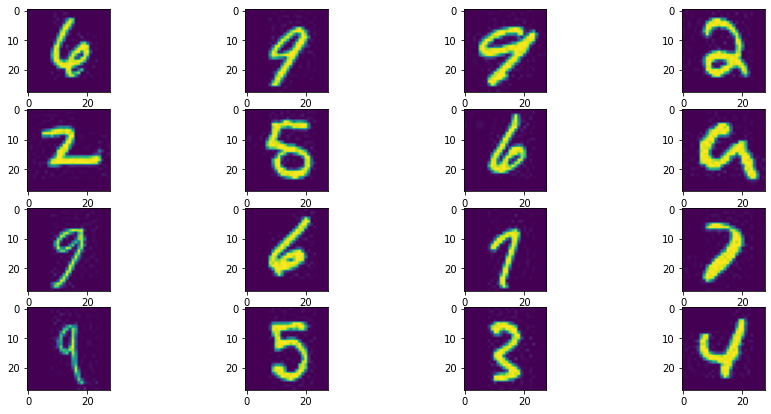

In [31]:
### Visualize original sample
plt.figure(figsize = (15, 7))
for i in range(s.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(s[i])
plt.show(); plt.close()

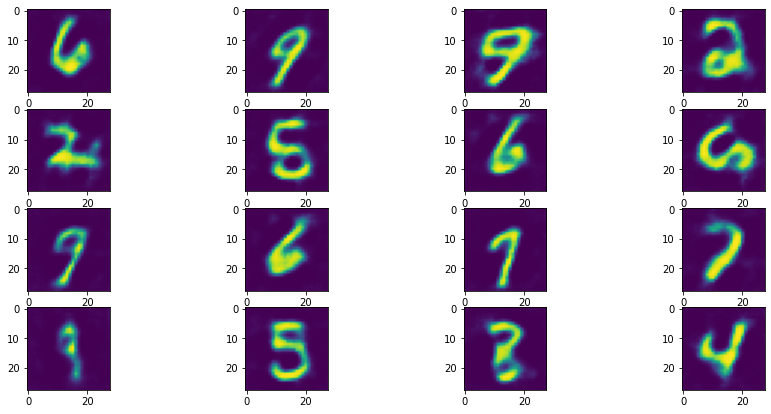

In [38]:
### Visualize reconstructed sample
plt.figure(figsize = (15, 7))
for i in range(s_.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(s_[i])
plt.show(); plt.close()

In [33]:
### Evaluate trained autoencoder loss
model.evaluate(test_x)

2000/2000 [==============================] - 587s 289ms/step - loss: 0.0168


0.01683618314564228

In [ ]:
epochs = 10
optimizer = optimizers.Adam(learning_rate = 1e-3)

for epoch in range(epochs):
    for batch in train_x:
        train_step(model, batch, optimizer)
    generate_and_save_images(model, sample[0], save_image = True)
    

In [39]:
dir(tf)

['AggregationMethod',
 'Assert',
 'CriticalSection',
 'DType',
 'DeviceSpec',
 'GradientTape',
 'Graph',
 'IndexedSlices',
 'IndexedSlicesSpec',
 'Module',
 'Operation',
 'OptionalSpec',
 'RaggedTensor',
 'RaggedTensorSpec',
 'RegisterGradient',
 'SparseTensor',
 'SparseTensorSpec',
 'Tensor',
 'TensorArray',
 'TensorArraySpec',
 'TensorShape',
 'TensorSpec',
 'TypeSpec',
 'UnconnectedGradients',
 'Variable',
 'VariableAggregation',
 'VariableSynchronization',
 '_API_MODULE',
 '_LazyLoader',
 '__all__',
 '__builtins__',
 '__cached__',
 '__compiler_version__',
 '__cxx11_abi_flag__',
 '__doc__',
 '__file__',
 '__git_version__',
 '__internal__',
 '__loader__',
 '__monolithic_build__',
 '__name__',
 '__operators__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_absolute_import',
 '_api',
 '_compat',
 '_current_file_location',
 '_current_module',
 '_distutils',
 '_division',
 '_estimator_module',
 '_fi',
 '_inspect',
 '_keras_module',
 '_keras_package',
 '_ll',
 '_logging',
 

In [41]:
dir(tf.math)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'abs',
 'accumulate_n',
 'acos',
 'acosh',
 'add',
 'add_n',
 'angle',
 'argmax',
 'argmin',
 'asin',
 'asinh',
 'atan',
 'atan2',
 'atanh',
 'bessel_i0',
 'bessel_i0e',
 'bessel_i1',
 'bessel_i1e',
 'betainc',
 'bincount',
 'ceil',
 'confusion_matrix',
 'conj',
 'cos',
 'cosh',
 'count_nonzero',
 'cumprod',
 'cumsum',
 'cumulative_logsumexp',
 'digamma',
 'divide',
 'divide_no_nan',
 'equal',
 'erf',
 'erfc',
 'erfcinv',
 'erfinv',
 'exp',
 'expm1',
 'floor',
 'floordiv',
 'floormod',
 'greater',
 'greater_equal',
 'igamma',
 'igammac',
 'imag',
 'in_top_k',
 'invert_permutation',
 'is_finite',
 'is_inf',
 'is_nan',
 'is_non_decreasing',
 'is_strictly_increasing',
 'l2_normalize',
 'lbeta',
 'less',
 'less_equal',
 'lgamma',
 'log',
 'log1p',
 'log_sigmoid',
 'log_softmax',
 'logical_and',
 'logical_not',
 'logical_or',
 'logical_xor',
 'maximum',
 '

In [ ]:
tf.math.rint